In [ ]:
# Mount Google Drive so we can access data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install idx2numpy package for extracting data
!pip install idx2numpy

In [ ]:
# Import packages
import os
import json
import gzip
import torch
import torchvision
import numpy as np 
import pandas as pd

import idx2numpy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as transforms
import matplotlib.pyplot as plt

In [ ]:
def load_one_dataset(path):
    '''
    Convenience function to load a single dataset
    '''
    f = gzip.open(path, 'rb')
    data = torch.from_numpy(idx2numpy.convert_from_file(f))
    f.close()
    
    return(data)


def load_all_datasets(train_imgs, train_labs, test_imgs, test_labs, batch_size):
    '''
    Load training as well as test images here
    '''
    train_images = load_one_dataset(train_imgs).type(torch.float32)
    train_labels = load_one_dataset(train_labs).type(torch.long)
    train = list(zip(train_images, train_labels))

    test_images = load_one_dataset(test_imgs).type(torch.float32)
    test_labels = load_one_dataset(test_labs).type(torch.long)
    test = list(zip(test_images, test_labels))
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return(train_loader, test_loader)

In [ ]:
def add_noise(img, quadrants):
  '''
  Randomly remove 1 or 2 quadrants
  from the input image.
  '''
  # Get the number of quadrants to erase
  n_quads_to_erase = np.random.choice([1, 2])

  print(n_quads_to_erase)

  # Get which quadrants to erase
  quads_to_erase = np.random.choice([1, 2, 3, 4], size = n_quads_to_erase)

  print(quads_to_erase)
  
  # Create a copy of the image
  noisy_img = img.clone()

  # Now erase the quadrants
  for quad in quads_to_erase:
    noisy_img = transforms.erase(noisy_img, *quadrants[quad])
  
  # Return statement
  return(noisy_img)

In [ ]:
def plot_image(img):
  '''
  Take an image stored as a Torch
  tensor and display it in the notebook
  '''
  # Display the img
  plt.imshow(img.numpy(), cmap= 'gray')

In [ ]:
def test_noise():
  '''
  Test the noise function
  '''
  # Just for testing out noise function
  data_dir = '/content/drive/MyDrive/data'

  # Set paths
  paths = {
        'train_imgs': os.path.join(data_dir, 'train-images-idx3-ubyte.gz'),
        'train_labs': os.path.join(data_dir, 'train-labels-idx1-ubyte.gz'),
        'test_imgs': os.path.join(data_dir,'t10k-images-idx3-ubyte.gz'),
        'test_labs': os.path.join(data_dir,'t10k-labels-idx1-ubyte.gz')
  }

  # Load datasets
  train_loader, test_loader = load_all_datasets(**paths, batch_size = 32)

  # Get the next batch from the train loader
  images, labels = iter(train_loader).next()

  # Store the quadrant definitions: move this into training loop later
  quadrants = {
      
      1: [0, 0, 14, 14, 255], 
      2: [0, 14, 14, 14, 255],
      3: [14, 0, 14, 14, 255],
      4: [14, 14, 14, 14, 255],
  }

  # Take the first image in the batch
  img = images[0]

  # Get noisy image
  noisy_img = add_noise(img, quadrants)

  return(img, noisy_img)

In [ ]:
# Get image and noisy image
img, noisy_img = test_noise()

2
[2 4]


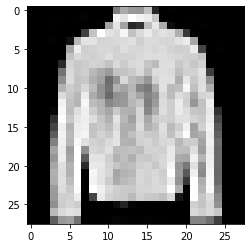

In [ ]:
# Show original image
plot_image(img)

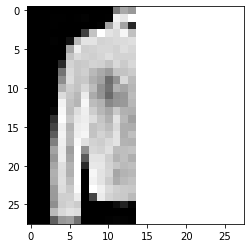

In [ ]:
# Show noisy image
plot_image(noisy_img)

In [ ]:
class denoising_autoencoder(nn.Module):
  
  def __init__(self):
    
    super(denoising_autoencoder,self).__init__()
    
    self.encoder=nn.Sequential(
                  nn.Linear(28*28,256),
                  nn.ReLU(True),
                  nn.Linear(256,128),
                  nn.ReLU(True),
                  nn.Linear(128,64),
                  nn.ReLU(True)
        
                  )
    
    self.decoder=nn.Sequential(
                  nn.Linear(64,128),
                  nn.ReLU(True),
                  nn.Linear(128,256),
                  nn.ReLU(True),
                  nn.Linear(256,28*28),
                  nn.Sigmoid(),
                  )
    
 
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    
    return x